# Майнор ВШЭ
## Прикладные задачи анализа данных 2020
## Семинар 12: NER и лингвомодели

Cегодня поговорим об одной из самых популярных задач NLP – извлечении именованных сущностей (Named-entity recognition, NER).

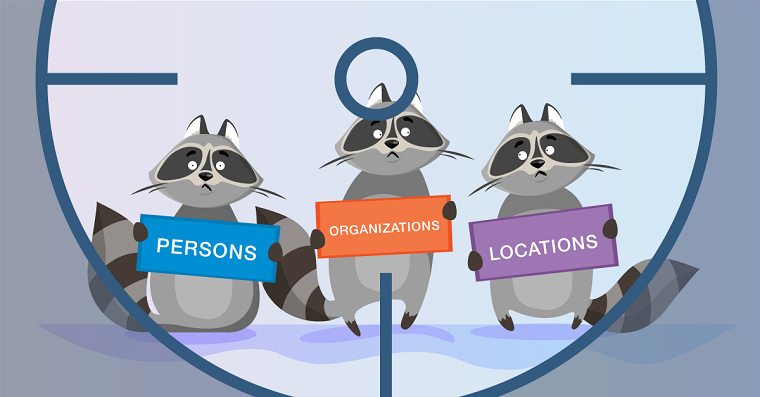


Первая задача, с решения которой начинается процесс работы каждой NLP системы, это необходимость максимально детального разбора пользовательского запроса и извлечения из него всей доступной в нем информации.  
  
NLP система должна:  
    1) Разбить текст запроса на составляющие (слова, токены)  
    2) Привести их в базовую форму (леммы, стеммы). Получить, если это необходимо, сведения о частях речи и прочую низкоуровневую информацию.  
    3) Распознать слова и словосочетания, то есть вычленить из текста именованные сущности и попытаться извлечь из них так называемые нормализованные значения.  

Этот процесс называется распознаванием именованных сущностей — NER, а модули, занимающиеся их извлечением — компонентами NER.

Допустим, есть новостной текст, и мы хотим выделить в нем сущности (некоторый заранее зафиксированный набор — например, персоны, локации, организации, даты и т.д.)   
Задача NER – понять, что участок текста “июль 1805 года” является датой, “Анна Павловна Шерер” – персоной и т.д.

На входе текст, на выходе структурированные, нормализованные объекты, например, с именами, адресами, датами.

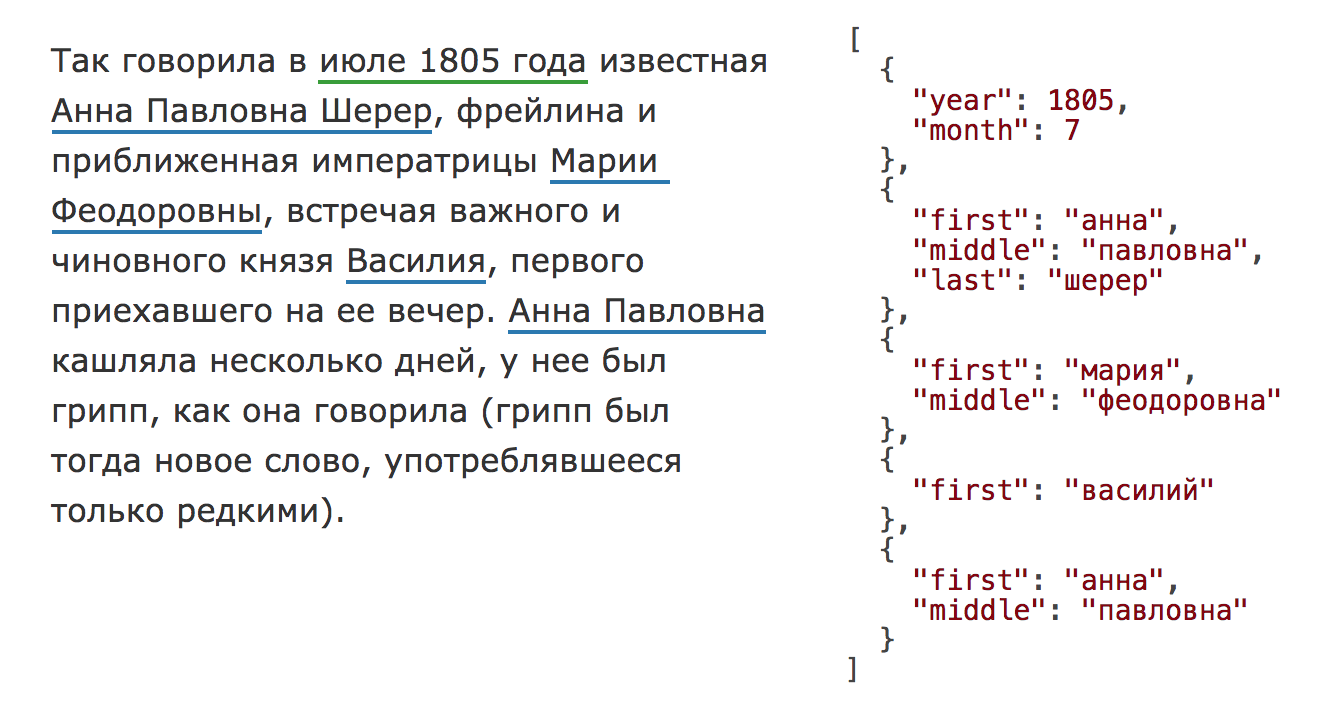

Что такое именованные сущности?  
В первой, классической постановке, которая была сформулирована на конференции MUC-6 в 1995 году, это персоны, локации и организации. С тех пор появилось несколько доступных корпусов, в каждом из которых свой набор именованных сущностей. Обычно к персонам, локациям и организациям добавляются новые типы сущностей.  
Самые распространенные из них — числовые (даты, денежные суммы), а также сущности Misc (от miscellaneous — прочие именованные сущности; пример — iPhone X ).

Для английского языка существует масса коммерческих и открытых решений: Spacy, Stanford NER, OpenNLP, NLTK, MITIE, Google Natural Language API, ParallelDots, Aylien, Rosette, TextRazor.  
Для русского тоже есть хорошие решения, но они в основном закрытые: DaData, Abbyy Infoextractor, Promt и др.
Есть неплохой открытый natasha и deeppavlov

Разберем на практике некоторые из них

## 1 Спарсим случайную статью для анализа

In [ ]:
import numpy as np
import pandas as pd
from os import path
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
!pip install beautifulsoup4

In [ ]:
import requests
from bs4 import BeautifulSoup
import re

In [ ]:
requests.get("http://rbc.ru/")

In [ ]:
%%time
resp = requests.get("https://lenta.ru/news/2020/04/20/12/")
print("cookies:", resp.cookies)
print("time to download:", resp.elapsed)
print("page encoding:", resp.encoding)
print("Server response: ", resp.status_code)
print("Is everything ok? ", resp.ok)
print("Page's URL: ", resp.url)

In [ ]:
resp.text[:1000]

In [ ]:
BeautifulSoup(resp.text, "html5lib").get_text()

In [ ]:
bs = BeautifulSoup(resp.text, "html5lib") 
title = bs.h1.text
text = BeautifulSoup(" ".join([p.text for p in bs.find_all("p")]), "html5lib").get_text()
print(title, "\n-----\n", text)

## 2 Natasha

[Наташа](https://natasha.readthedocs.io/ru/latest/) — это аналог Томита-парсера для Питона (Yargy-парсер) плюс набор готовых правил для извлечения имён, адресов, дат, сумм денег и других сущностей.

Сейчас в Наташе есть правила для извлечения имён, адресов, дат и сумм денег.  
Есть ещё правила для названий организаций и географических объектов, но у них не очень высокое качество.

In [ ]:
!pip install natasha

### 2.1 Имена

In [ ]:
from natasha import NamesExtractor
from natasha.markup import show_markup, show_json

extractor = NamesExtractor()

matches = extractor(text)
spans = [_.span for _ in matches]
facts = [_.fact.as_json for _ in matches]
show_markup(text, spans)
show_json(facts)

В 2016 году проходило соревнование factRuEval-2016 по извлечению именованных сущностей. Среди участников были крупные компании: ABBYY, RCO.  
У топовых решений F1-мера для имён была 0.9+. У Наташи результат хуже — 0.78. Проблема в основном c иностранными именами и сложными фамилиями, например: «Харуки Мураками», "… главой Афганистана Хамидом Карзаем", «Остап Бендер встречается с Кисой Воробьяниновым ...»  Для текстов с русскими именами качество получается ~0.95.


#### Задание 1

In [ ]:
### Найти статью с русскими именами и вывести имена из статьи
# Как вариант можно взять 
# https://www.popmech.ru/design/571334-shedevry-otechestvennogo-kinematografa-snyatye-vo-vremya-voyny/

### 2.2 Адреса

Интерфейс такой же как для имён, только NamesExtractor меняется на AddressExtractor:

In [ ]:
resp = requests.get("https://lenta.ru/news/2020/04/13/gorim/")

bs = BeautifulSoup(resp.text, "html5lib") 
title = bs.h1.text
text = BeautifulSoup(" ".join([p.text for p in bs.find_all("p")]), "html5lib").get_text()
print(title, "\n-----\n", text)

In [ ]:
from natasha import AddressExtractor
from natasha.markup import show_markup, show_json

extractor = AddressExtractor()

matches = extractor(text)
spans = [_.span for _ in matches]
facts = [_.fact.as_json for _ in matches]
show_markup(text, spans)
show_json(facts)

In [ ]:
extractor(text)

В factRuEval-2016 участникам предлагалось извлекать имена, названия организаций и географические объекты.  
Независимых тестовых данных для оценки качества работы с адресами, на сколько я знаю, не существует. За несколько лет работы у нас накопились сотни тысяч строк вида «Адрес: 443041 г. Самара ул. Ленинская, д.168», «Адрес г. Иркутск, ул. Байкальская, д. 133, офис 1 (вход со двора).». Для оценки качества сделана случайная выборка из 1000 адресов, результаты проверены вручную, ~90% строк обработались корректно. Проблемы возникают, в основном, с названиями улиц, например: «г. Волжск, 2-ая промышленная, стр. 2», «111674, г. Москва, Дмитриевского, д. 17».

### 2.3 Другие правила

Ещё в Наташе есть правила для дат и денег. Интерфейс такой же как у AddressExtractor и NamesExtractor.  
*DatesExtractor*  
*MoneyExtractor*

#### Задание 2

In [ ]:
### Найти и загрузить статью с датами и вывести даты из статьи
# Как вариант можно взять 
# https://www.popmech.ru/technologies/562514-sudba-teleskopa-kak-zakonchitsya-zhizn-samogo-zorkogo-pribora-v-mire/

## 3 SpaCy -- NER

Использование библиотеки SpaCy

SpaCy — это open-source библиотека для NLP, написанная на Python и Cython. В отличие от NLTK, который широко используется для преподавания и исследований, spaCy фокусируется на предоставлении программного обеспечения для разработки.

In [ ]:
# !pip install spacy

Удобная инструкция для инсталляции на   
https://spacy.io/usage

In [ ]:
# !python -m spacy download en_core_web_sm

In [ ]:
import spacy
import en_core_web_sm

# Загружаем модель
# nlp = spacy.load('en_core_web_sm')
nlp = en_core_web_sm.load()

# Передаем текст в модель
doc = nlp('i love coffee')

### Некоторые основные возможности NLP в библиотеке spaCy

#### Токенизация

Текст необходимо токенизировать и spaCy позволяет нам это сделать.  
> _"Given a character sequence and a defined document unit, tokenization is the task of chopping it up into pieces, called tokens."_

(words, sentences, punctuation, etc.)

Подробности реализации здесь:
https://nlp.stanford.edu/IR-book/html/htmledition/tokenization-1.html

В spaCy многие конструкции обозначаются тегами, например теги nsubj, prt, RB и др.  
Полную расщифровку можно получить с помощью explain()

In [ ]:
spacy.explain('nsubj')

Полное описание возможностей есть на странице spaCy
https://spacy.io/api/annotation

#### Часть речи (Part Of Speech POS)

POS для английского языка: noun, verb, adjective, adverb, pronoun, preposition, conjunction, interjection, numeral, article, determiner

https://en.wikipedia.org/wiki/Part_of_speech

#### Синтаксическая зависимость (Syntactic dependency DEP)

DEP показывает связи между токенами

"I" это _nominal subject_ и "coffee" это _direct object_.  Они соединены с помощью _root_ "love".

#### Нарисуем визуализацию

Построим дерево зависимостей с помощью displaCy 

In [ ]:
from spacy import displacy

# Outside of jupyter, use displacy.serve()
displacy.render(doc, style='dep', jupyter=True)

#### Задание 3

In [ ]:
### Придумайте более сложное предложение и постройте синтаксичекую зависимость для него


Если передаем в dос предложение без именованных сущностей (организации, имена и тп), то при попытке вывести сущности получим Warning

In [ ]:
displacy.render(doc, style='ent', jupyter=True)

In [ ]:
doc.ents

Возьмем предложение с именованными сущностями

In [ ]:
doc = nlp('Apple is looking at buying U.K. startup for $1 billion')

In [ ]:
displacy.render(doc, style='dep', jupyter=True)

In [ ]:
displacy.render(doc, style='ent', jupyter=True)

### Доступ к атрбутам токенов

In [ ]:
print(doc[0])
print(doc[0].text)

In [ ]:
for token in doc:
    print(token)

In [ ]:
for token in doc:
    print(token.text, token.pos_, token.dep_)

In [ ]:
print(f'{"text":<10} {"part of speech":<15} {"description":<15} {"dependency":<15} {"description":<30} {"lemma":<20} {"is stop":<10}')

for token in doc:
    print(f'{token.text:<10} {token.pos_:<15} {str(spacy.explain(token.pos_)):<15} {token.dep_:<15} {str(spacy.explain(token.dep_)):<30} {token.lemma_:<20} {token.is_stop:<10}')

#### Lemma

Лемма слова.

Например: "be" основа "am", "are" и "is"

https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html#2378

#### Стоп слова

Стоп-слова -- это слова, которые часто удаляются из текста перед последующим анализом.

Подробнее:
https://github.com/explosion/spaCy/blob/master/spacy/lang/en/stop_words.py

Стоп-слова можно посмотреть здесь `nlp.Defaults.stop_words`

In [ ]:
print(nlp.Defaults.stop_words)

# Можно добавлять и удалять слова из списка
# https://spacy.io/usage/v2#migrating-saving-loading

# nlp.Defaults.stop_words.add("across")
# nlp.Defaults.stop_words.remove("above")

# Сохранение и загрузка модели

Сохранение модели

```python
some_dir = '/path/to/directory' 
nlp.to_disk(some_dir)
```

Загрузка модели

```python
nlp = spacy.load(some_dir)
```

# Поиск именованных сущностей в тексте

Источник: https://www.techinasia.com/yellow-messenger-banks-20m

Используем large модель ('en_core_web_lg') чтобы проанализировать статью.

In [ ]:
text = '''
Global demand for conversational AI systems has become urgent and vast. According to research from advisory firm Gartner, one in every three companies worldwide has already integrated the technology into their operations.

India-based Yellow Messenger, a startup that provides businesses with an AI chatbot for customer engagement, said it has raised US$20 million in series B money to capture more of the growing market.

The new funding round, which was led by Lightspeed Venture Partners and Lightspeed India, bumps up the company’s total funding to US$24 million, according to a statement.

Yellow Messenger looks to use the fresh capital to fuel international growth across Latin America and Asia Pacific, as well as new regions such as the US and Europe.

In addition, it plans to invest further in product innovation, which includes improving its bot’s multilingual voice capabilities and expanding enterprise integrations. Currently, its chatbots are available in over 120 languages, including Bahasa, Bengali, Cantonese, English, Hindi, and Thai.

The startup is also looking to launch a developer marketplace for virtual assistants, which will enable third-party developers to create, launch, and distribute their own chatbots to Yellow Messenger clients.

Through a partnership with Facebook Messenger, the company said it has recently been appointed by the National Health Authority of India to provide state governments with chatbots to help with citizen engagement amid the Covid-19 pandemic.

Raghu Ravinutala, CEO and co-founder of Yellow Messenger, said that at this time, the startup has seen a surge in global demand from the banking, healthcare, food and beverage, retail, and ecommerce sectors as a result of the crisis. In response, the company has deployed special chatbots for enterprises tailored to drive business continuity.

Yellow Messenger was founded in 2017. It claims to have been growing 5x in bookings year on year since its establishment. It has over 100 clients globally, including companies such as Accenture, Flipkart, Grab, and Xiaomi India.
'''

In [ ]:
# !python -m spacy download en_core_web_lg
# nlp = spacy.load('en_core_web_lg')

# import en_core_web_lg
nlp = en_core_web_sm.load()

In [ ]:
doc = nlp(text)
print(doc)

### Выведем предложения

In [ ]:
for sent in doc.sents:
    print(sent)

In [ ]:
sents_l = list(doc.sents)
print(sents_l[0])
print(sents_l[0][0])
print(sents_l[0][0].pos_)

### Визуализация сущностей в статье

In [ ]:
displacy.render(doc, style='ent', jupyter=True)

### Описание сущностей

In [ ]:
print(f'{"entity":<50} {"label":<10} description')
for ent in doc.ents:
    print(f'{ent.text:<50} {ent.label_:<10} {spacy.explain(ent.label_)}')

# Дообучение модели

Если точности нашшей модели недостаточно, можем дообучить предобученную модель.  
Это позволит нам не использовать огромный датасет для обучения.

Подробнее и по шагам описано здесь: https://spacy.io/usage/training

[API documentation](https://spacy.io/api)

In [ ]:
# !python3 -m spacy download en_core_web_sm
# !pip3 install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz

In [ ]:
import random
from pathlib import Path
from spacy.util import minibatch, compounding


# данные для обучения
TRAIN_DATA = [
    ("Yellow Messenger is a startup in India that provides businesses with an AI chatbot.", {"entities": [(0, 16, "ORG"), (33, 38, "GPE")]}),
    ("The co-founder of Yellow Messenger said some things.", {"entities": [(18, 33, "ORG")]}),
    ("Facebook developed the service Facebook Messenger.", {"entities": [(0, 8, "ORG"), (31, 49, "PRODUCT")]})
]


def train_ner(model=None, output_dir=None, n_iter=100):
    """Load the model, set up the pipeline and train the entity recognizer."""
    if model is not None:
        nlp = spacy.load(model)  # load existing spaCy model
        print("Loaded model '%s'" % model)
    else:
        nlp = spacy.blank("en")  # create blank Language class
        print("Created blank 'en' model")

    # create the built-in pipeline components and add them to the pipeline
    # nlp.create_pipe works for built-ins that are registered with spaCy
    if "ner" not in nlp.pipe_names:
        ner = nlp.create_pipe("ner")
        nlp.add_pipe(ner, last=True)
    # otherwise, get it so we can add labels
    else:
        ner = nlp.get_pipe("ner")

    # add labels
    for _, annotations in TRAIN_DATA:
        for ent in annotations.get("entities"):
            ner.add_label(ent[2])

    # get names of other pipes to disable them during training
    pipe_exceptions = ["ner", "trf_wordpiecer", "trf_tok2vec"]
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe not in pipe_exceptions]
    with nlp.disable_pipes(*other_pipes):  # only train NER
        # reset and initialize the weights randomly – but only if we're
        # training a new model
        if model is None:
            nlp.begin_training()
        for itn in range(n_iter):
            random.shuffle(TRAIN_DATA)
            losses = {}
            # batch up the examples using spaCy's minibatch
            batches = minibatch(TRAIN_DATA, size=compounding(4.0, 32.0, 1.001))
            for batch in batches:
                texts, annotations = zip(*batch)
                nlp.update(
                    texts,  # batch of texts
                    annotations,  # batch of annotations
                    drop=0.5,  # dropout - make it harder to memorise data
                    losses=losses,
                )
            print("Losses", losses)

    # test the trained model
    for text, _ in TRAIN_DATA:
        doc = nlp(text)
        print("Entities", [(ent.text, ent.label_) for ent in doc.ents])
        print("Tokens", [(t.text, t.ent_type_, t.ent_iob) for t in doc])

    # save model to output directory
    if output_dir is not None:
        output_dir = Path(output_dir)
        if not output_dir.exists():
            output_dir.mkdir()
        nlp.to_disk(output_dir)
        print("Saved model to", output_dir)


new_model_dir = '/'
train_ner(model='en_core_web_sm', output_dir=new_model_dir, n_iter=100)


In [ ]:
text = '''
Global demand for conversational AI systems has become urgent and vast. According to research from advisory firm Gartner, one in every three companies worldwide has already integrated the technology into their operations.

India-based Yellow Messenger, a startup that provides businesses with an AI chatbot for customer engagement, said it has raised US$20 million in series B money to capture more of the growing market.

The new funding round, which was led by Lightspeed Venture Partners and Lightspeed India, bumps up the company’s total funding to US$24 million, according to a statement.

Yellow Messenger looks to use the fresh capital to fuel international growth across Latin America and Asia Pacific, as well as new regions such as the US and Europe.

In addition, it plans to invest further in product innovation, which includes improving its bot’s multilingual voice capabilities and expanding enterprise integrations. Currently, its chatbots are available in over 120 languages, including Bahasa, Bengali, Cantonese, English, Hindi, and Thai.

The startup is also looking to launch a developer marketplace for virtual assistants, which will enable third-party developers to create, launch, and distribute their own chatbots to Yellow Messenger clients.

Through a partnership with Facebook Messenger, the company said it has recently been appointed by the National Health Authority of India to provide state governments with chatbots to help with citizen engagement amid the Covid-19 pandemic.

Raghu Ravinutala, CEO and co-founder of Yellow Messenger, said that at this time, the startup has seen a surge in global demand from the banking, healthcare, food and beverage, retail, and ecommerce sectors as a result of the crisis. In response, the company has deployed special chatbots for enterprises tailored to drive business continuity.

Yellow Messenger was founded in 2017. It claims to have been growing 5x in bookings year on year since its establishment. It has over 100 clients globally, including companies such as Accenture, Flipkart, Grab, and Xiaomi India.
'''

In [ ]:
nlp = spacy.load(new_model_dir)

doc = nlp(text)

displacy.render(doc, style='ent', jupyter=True)

# Результаты

Обучение помогло модели распознать корректно _Yellow Messenger_ как компанию и _Facebook Messenger_ как продукт.
Иногда это может приводить к переобучению и ваши предыдущие сущности могут отображаться некорректно. В таких случаях spaCy позволяет также создавать отдельно жесткие правила под необходимые сущности.


#### Задание 4

Найдите текст на английском с неразмеченной сущностью и дообучите вашу модель, разметив в обучении эту сущность.